In [34]:
# Before running these commands, create a virtual environment (outside project directory) using python -m venv "dir_name/env_name"
%pip install deepxde
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [35]:
%pip install chart-studio
%pip install nbformat

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
import deepxde as dde
import numpy as np

In [ ]:
import tensorflow as tf

geo = dde.geometry.geometry_2d.Rectangle([-1, -1], [1]*2)
d = 2

T = 0.05
def dU(x):
    x = tf.cast(x, tf.float32)
    return tf.stack([
        4 * (x[:, 0] ** 2 - 1) * x[:, 0],     # ∂U/∂x₁
        0.6 * x[:, 1],                       # ∂U/∂x₂
        # add more if d > 2
    ], axis=1)


print(dU(np.array([[1, 1], [2, 1]])))

def committor(x, q):
    # Gradient ∇q
    print(x.shape)
    dq_list = [dde.gradients.jacobian(q, x, j=num) for num in range(d)]
    grad_q = tf.concat(dq_list, axis=1)  # shape [N, d]

    # Laplacian Δq
    dlap_q = sum(dde.gradients.hessian(q, x, i=num, j=num) for num in range(d))  # shape [N, 1]

    # Gradient of U
    grad_U = dU(x)  # shape [N, d]

    # Dot product ∇U · ∇q
    dot = tf.reduce_sum(grad_U * grad_q, axis=1, keepdims=True)

    dlap_q = tf.clip_by_value(dlap_q, -1e3, 1e3)
    dot = tf.clip_by_value(dot, -1e3, 1e3)

    tf.debugging.assert_all_finite(dlap_q, "dlap_q has NaNs")
    tf.debugging.assert_all_finite(dot, "dot(grad_U, grad_q) has NaNs")

    return -1 / T * dlap_q + dot


bc_a = dde.icbc.DirichletBC(geo, lambda x: 0, lambda x, on_boundary: on_boundary and np.isclose(x[0], -1) and np.isclose(x[1], -1))
bc_b = dde.icbc.DirichletBC(geo, lambda x: 1, lambda x, on_boundary: on_boundary and np.isclose(x[0], 1) and np.isclose(x[1], 1))


Tensor("stack_4:0", shape=(2, 2), dtype=float32)


In [188]:
data = dde.data.pde.TimePDE(
    geo,
    committor, 
    [bc_a, bc_b], 
    num_domain=2560,
    num_boundary=80,
    num_test=2560
)

In [189]:
net = dde.maps.FNN([2] + [64] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=5000)

Compiling model...
Building feed-forward neural network...
'build' took 0.157240 s

(None, 2)
(None, 2)
'compile' took 1.829862 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.96e-01, nan, 9.89e-01]         [2.86e-01, nan, 9.89e-01]         []  

Best model at step 0:
  train loss: inf
  test loss: inf
  test metric: 

'train' took 4.900634 s



In [17]:
model.compile("L-BFGS-B")
losshistory, train_state=model.train()

Compiling model...
'compile' took 0.315345 s

Training model...

Step      Train loss                        Test loss                         Test metric
5000      [1.65e-04, 7.84e-05, 1.63e-04]    [1.19e-04, 7.84e-05, 1.63e-04]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  Objective function value: 0.000407
  Number of iterations: 1
  Number of functions evaluations: 37
5016      [1.65e-04, 7.84e-05, 1.63e-04]    [1.19e-04, 7.84e-05, 1.63e-04]    []  

Best model at step 4000:
  train loss: 2.45e-04
  test loss: 1.72e-04
  test metric: []

'train' took 0.851908 s



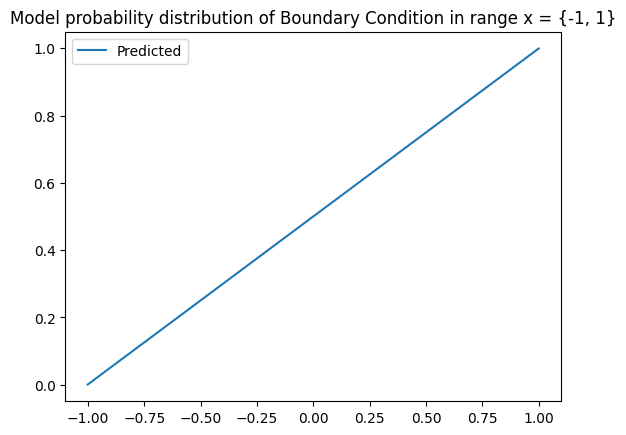

In [31]:
import matplotlib.pyplot as plt

x = np.linspace(-1, 1, 200).reshape(-1,1)
u_pred = model.predict(x)
plt.plot(x, u_pred, label="Predicted")
plt.legend()
plt.title("Model probability distribution of Boundary Condition in range x = {-1, 1}")
plt.show()